In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [11]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [2]:
train=pd.read_csv("tit_train.csv")
test=pd.read_csv("tit_test.csv")

In [3]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


<AxesSubplot:xlabel='Sex', ylabel='Survived'>

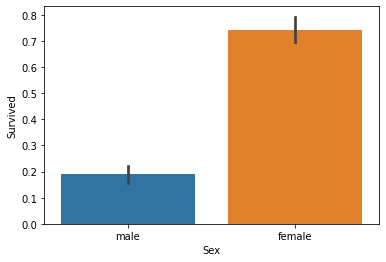

In [5]:
sns.barplot(x='Sex',y='Survived',data=train)

In [8]:
IDtest = test["PassengerId"]

# OUTLIER DETECTION AND HANDLING

In [12]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers 

In [16]:
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

In [17]:
Outliers_to_drop

[27, 88, 159, 180, 201, 324, 341, 792, 846, 863]

In [18]:
train.loc[Outliers_to_drop] # Show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [19]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [20]:
    ## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [21]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

In [22]:
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [23]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [24]:
train.isnull().sum(),train.dtypes

(PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            170
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          680
 Embarked         2
 dtype: int64,
 PassengerId      int64
 Survived         int64
 Pclass           int64
 Name            object
 Sex             object
 Age            float64
 SibSp            int64
 Parch            int64
 Ticket          object
 Fare           float64
 Cabin           object
 Embarked        object
 dtype: object)

In [25]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# FEATURE ANALYSIS OR EDA

<AxesSubplot:xlabel='SibSp', ylabel='Survived'>

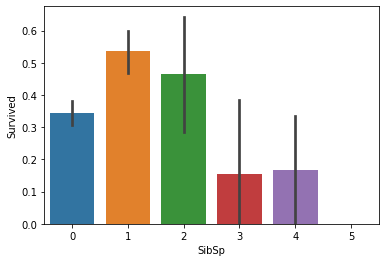

In [28]:
sns.barplot(x="SibSp",y="Survived",data=train)

<AxesSubplot:xlabel='Parch', ylabel='Survived'>

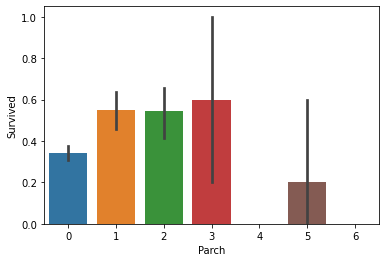

In [31]:
sns.barplot(x='Parch',y='Survived',data=train,label=)

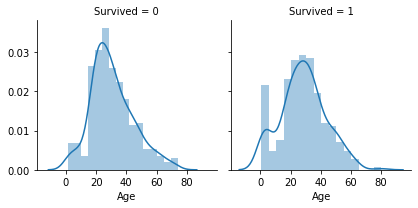

In [32]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

Text(0, 0.5, 'Survived')

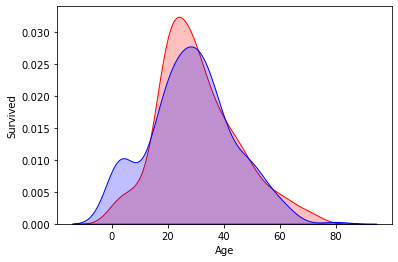

In [47]:
g=sns.kdeplot(train["Age"][(train["Surv
g.set_xlabel('Age')
g.set_ylabel('Survived')ived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)


In [42]:
dataset["Fare"].isnull().sum()

1

In [51]:
dataset['Fare']=dataset['Fare'].fillna(dataset['Fare'].median())

<AxesSubplot:xlabel='Fare', ylabel='Density'>

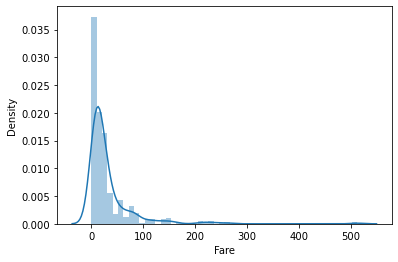

In [55]:
sns.distplot(train['Fare'])

In [56]:
dataset["Fare"].skew()

4.511862011583735

In [60]:
dataset['Fare'].mean(),dataset['Fare'].median(),dataset['Fare'].std()

(32.55511247113167, 14.4542, 50.677612580115074)

In [63]:
dataset['Fare']=dataset['Fare'].map(lambda i : np.log(i) if i> 0 else 0)  #log of data to reduce the skewness

In [65]:
dataset["Fare"].skew() ,dataset['Fare'].mean(),dataset['Fare'].median(),dataset['Fare'].std()

(0.5727996620084405, 2.897084514670295, 2.6709850297651974, 0.9947040964772934)

<AxesSubplot:xlabel='Fare', ylabel='Count'>

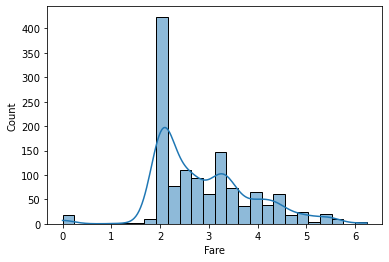

In [68]:
sns.histplot(dataset['Fare'],kde=True)

Text(0, 0.5, 'Survived prob')

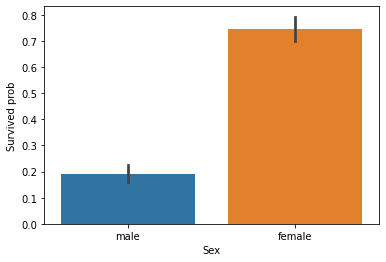

In [75]:
g=sns.barplot(x='Sex',y='Survived',data=train)
g.set_xlabel('Sex')
g.set_ylabel('Survived prob')

In [83]:
train[['Sex','Survived']].groupby('Sex').skew()
#rain[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,-1.145393
male,1.579940


<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

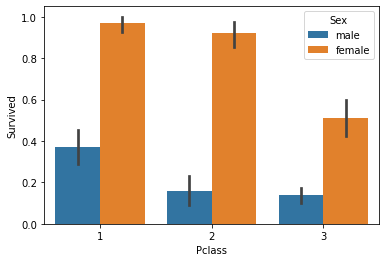

In [95]:
sns.barplot(x='Pclass',y='Survived',hue='Sex',data=dataset)

In [90]:
dataset['Embarked'].isnull().sum()

2

In [92]:
dataset['Embarked'].fillna(dataset['Embarked'].mode(),inplace=True)  #filled with mode since only two 

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

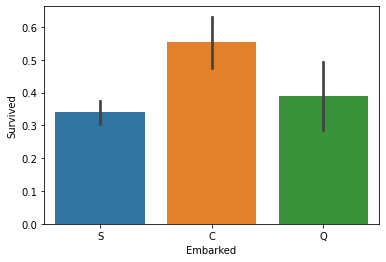

In [97]:
sns.barplot(x='Embarked',y='Survived',data=train)

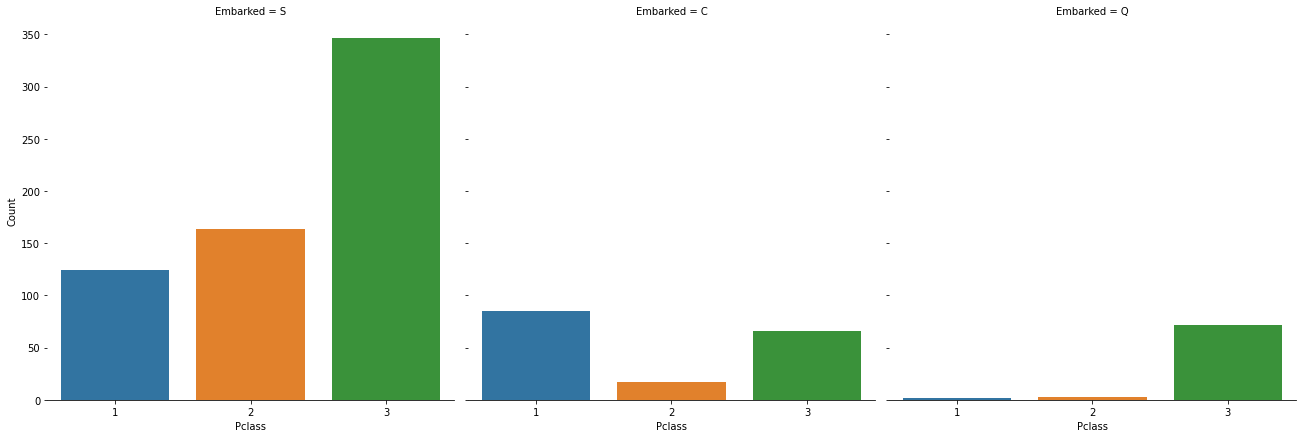

In [107]:
# Explore Pclass vs Embarked 
g = sns.factorplot("Pclass", col="Embarked",  data=train,size=(6), kind="count")#, palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

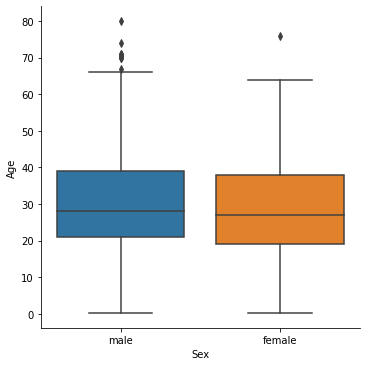

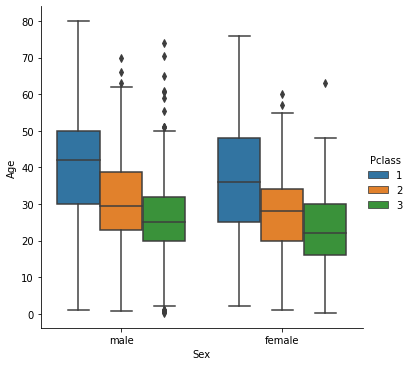

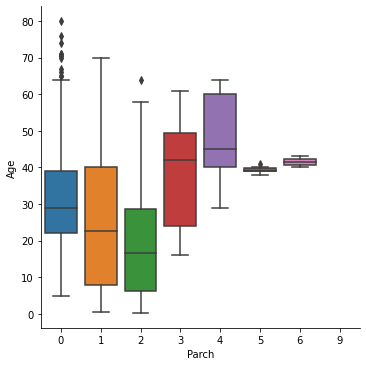

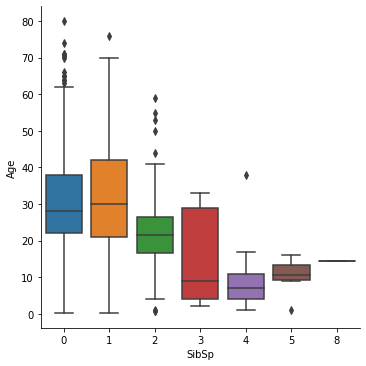

In [113]:
# Explore Age vs Sex, Parch , Pclass and SibSP
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

<AxesSubplot:xlabel='Sex', ylabel='Age'>

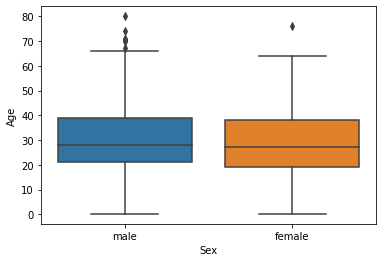

In [112]:
sns.boxplot(x='Sex',y='Age',data=dataset)

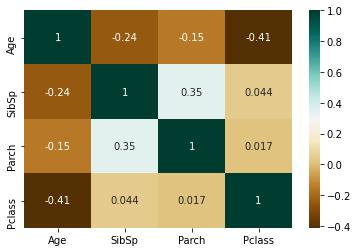

In [118]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),annot=True,cmap="BrBG")#,cmap="BrBG",annot=True)

In [120]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [124]:
index_NaN_Age =list(dataset['Age'].isnull().index)

In [126]:
age_med=dataset['Age'].median()

In [139]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) &
                               (dataset['Parch'] == dataset.iloc[i]["Parch"]) &
                               (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

<AxesSubplot:xlabel='Survived', ylabel='Age'>

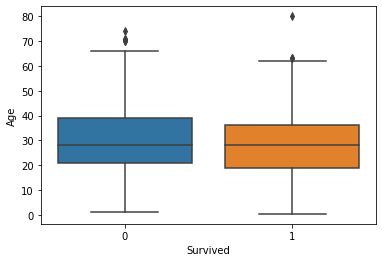

In [145]:
sns.boxplot(x="Survived", y = "Age",data = train)

<AxesSubplot:xlabel='Survived', ylabel='Age'>

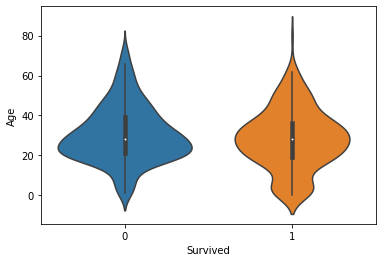

In [146]:
sns.violinplot(x='Survived',y='Age',data=train)

# FEATURE ENGINEERING

###### name column

In [149]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [158]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]] 
#very simple method to extract title(Mr/Mrs/Miss etc)  , first split with ",", then on that list take 1 postiion and split it with ".", and take 0the posiiton 
#so we get the tittle

In [170]:
dataset['Title']=pd.DataFrame(dataset_title)  #or pd.series(dataset_title)

In [161]:
dataset['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [172]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

<AxesSubplot:xlabel='Title', ylabel='count'>

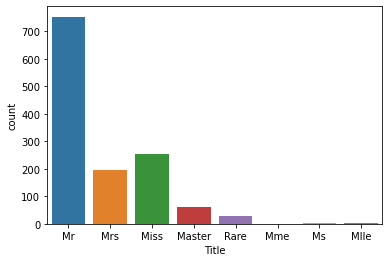

In [173]:
sns.countplot(dataset['Title'])

In [174]:
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

<AxesSubplot:xlabel='Title', ylabel='count'>

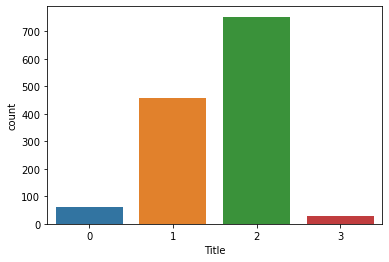

In [175]:
sns.countplot(dataset['Title'])

<AxesSubplot:xlabel='Title', ylabel='Survived'>

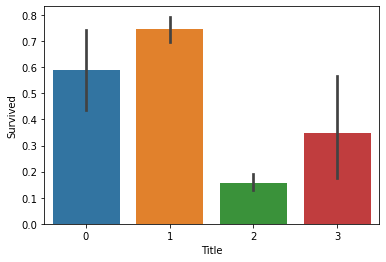

In [177]:
sns.barplot(x=dataset['Title'],y=dataset['Survived'])

In [178]:
#now dropped name variable and replace with title variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

###### Family

In [179]:
# Created a family size feature  from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1 #+1 for last passenger itself

<AxesSubplot:xlabel='Fsize', ylabel='Survived'>

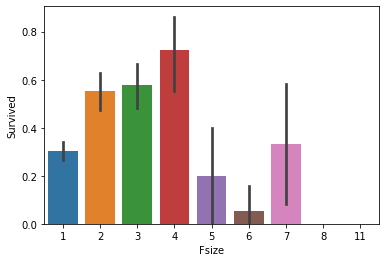

In [181]:
sns.barplot(x='Fsize',y='Survived',data=dataset)

In [182]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

In [183]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,S,2,2,0,1,0,0
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,C,1,2,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,1,1,0,0,0
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,S,1,2,0,1,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,S,2,1,1,0,0,0


In [184]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

###### cabin

In [185]:
dataset["Cabin"].isnull().sum()

1007

In [187]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

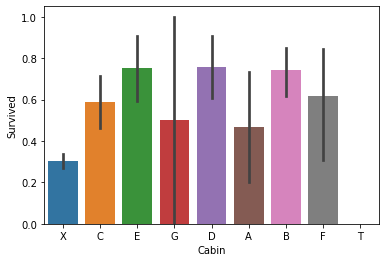

In [188]:
sns.barplot(data=dataset,x='Cabin',y='Survived')

In [248]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

###### ticket

In [189]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [190]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [192]:
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [193]:
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)

# MODEL CREATING

In [249]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True) #or test.drop(columns=['Survived'],inplace=True)

In [224]:
test.head(5)

,Sex,Age,SibSp,Parch,Fare,Cabin,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
881,0,34.5,0,0,2.057860,X,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
882,1,47.0,1,0,1.945910,X,2,0,1,0,...,0,0,0,0,0,0,1,0,0,1
883,0,62.0,0,0,2.270836,X,1,1,0,0,...,0,0,0,0,0,0,1,0,1,0
884,0,27.0,0,0,2.159003,X,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1
885,1,22.0,1,1,2.508582,X,3,0,0,1,...,0,0,0,0,0,0,1,0,0,1


#### Spliting train data

In [250]:
train['Survived']=train['Survived'].astype(int)

In [251]:
X_train=train.drop(columns=['Survived'])


In [227]:
Y_train=train['Survived']
X_train=train.drop(columns=['Survived'])


In [235]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

In [253]:
from sklearn.svm import SVC
from sklearn import svm


clf_svc=svm.SVC()
clf_svc.fit(X_train,Y_train)


SVC()

In [254]:
classifier =SVC(random_state=random_state)
cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4)

array([0.69662921, 0.70454545, 0.68181818, 0.80681818, 0.68181818,
       0.73863636, 0.71590909, 0.72727273, 0.79545455, 0.72727273])

In [255]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

In [256]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

In [258]:
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [264]:
cv_result = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

In [265]:
cv_result

,CrossValMeans,CrossValerrors,Algorithm
0,0.727617,0.041014,SVC
1,0.803728,0.043397,DecisionTree
2,0.805975,0.052802,AdaBoost
3,0.810457,0.050770,RandomForest
4,0.809359,0.052034,ExtraTrees
5,0.827464,0.041550,GradientBoosting
6,0.824093,0.038624,MultipleLayerPerceptron
7,0.795710,0.038224,KNeighboors
8,0.822932,0.033765,LogisticRegression
9,0.822932,0.038751,LinearDiscriminantAnalysis


<AxesSubplot:xlabel='CrossValerrors', ylabel='Algorithm'>

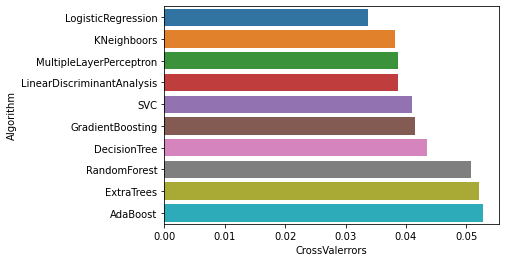

In [270]:
sns.barplot(x='CrossValerrors',y='Algorithm',data=cv_result.sort_values('CrossValerrors'))

In [268]:
# selected the best five models for hyperparameter tuning

# Hyper parameter Optimization or Tuning with  Grid Search

###### Adaboost

In [271]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [272]:
ada_best

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.2, n_estimators=2, random_state=7)

In [273]:
gsadaDTC.best_score_

0.818449948927477

###### Extra Tree classifier

In [274]:
ExtC = ExtraTreesClassifier()
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8297880490296221

In [286]:
ExtC_best = gsExtC.best_estimator_

###### SVC classifier

In [277]:

SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)



Fitting 10 folds for each of 28 candidates, totalling 280 fits


SVC(C=10, gamma=0.01, probability=True)

In [283]:
SVMC_best = gsSVMC.best_estimator_

In [278]:
# Best score
gsSVMC.best_score_

0.8331332992849847

###### RFC Parameters tunning 

In [279]:

RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [285]:
RFC_best = gsRFC.best_estimator_

###### Gradient boosting tunning

In [280]:


GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8308861082737489

In [284]:
GBC_best = gsGBC.best_estimator_

###### PLOT THE LEARNING RATE

In [281]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

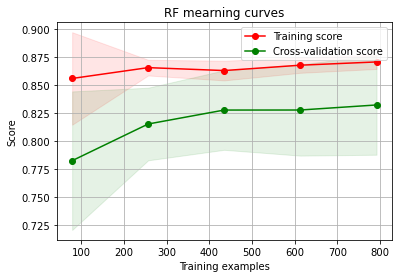

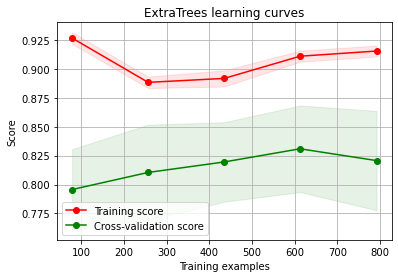

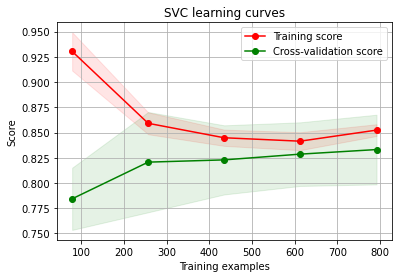

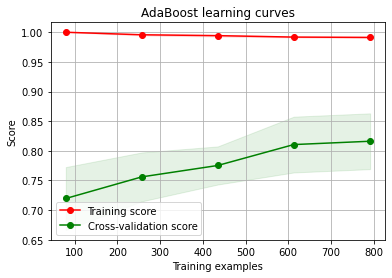

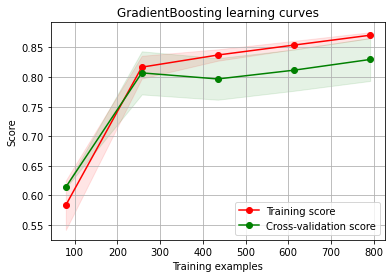

In [282]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF Learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees Learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC Learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost Learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting Learning curves",X_train,Y_train,cv=kfold)

###### Prediction for checking

In [287]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

In [288]:
# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

In [289]:
ensemble_results.head(3)

,RFC,ExtC,Ada,GBC,SVC
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,0,0


In [ ]:
g= sns.heatmap(ensemble_results.corr(),annot=True)

<AxesSubplot:>

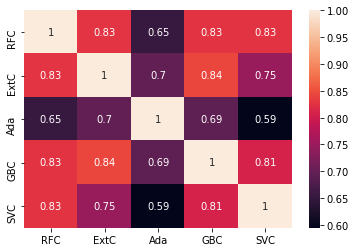

In [291]:
sns.heatmap(ensemble_results.corr(),annot=True,cbar=True)

# Creating Ensemble Modelling

###### Merging Models

In [ ]:
Used voting classifier to combine or merge the outcomes of all the models, used voting as soft than hard


In [292]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

In [293]:
Ensemble_train = votingC.fit(X_train, Y_train)

In [294]:
test_Survived = pd.Series(Ensemble_train.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_soft_voting.csv",index=False)